# Dogs breeds

https://youtu.be/JNxcznsrRb8?t=1h31m8s

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
torch.cuda.set_device(0)

Kaggle Dog Breed Identification. Get data from https://www.kaggle.com/c/dog-breed-identification

In [7]:
HOME = "/home/ubuntu"
PATH = HOME + "/data/dogbreed/"
sz = 224 # size
arch = resnext101_64
bs = 58 # batch size

In [8]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv))) - 1 # header is not counted (-1)
val_idxs = get_cv_idxs(n) # random 20% data for validation set

In [9]:
n

10222

In [10]:
len(val_idxs)

2044

In [8]:
# If you haven't downloaded weights.tgz yet, download the file.
#     http://forums.fast.ai/t/error-when-trying-to-use-resnext50/7555
#     http://forums.fast.ai/t/lesson-2-in-class-discussion/7452/222
#!wget -O fastai/weights.tgz http://files.fast.ai/models/weights.tgz

#!tar xvfz fastai/weights.tgz -C fastai

## Initial exploration

In [11]:
!ls {PATH}

labels.csv  sample_submission.csv  test  train


## Different types of data formats - here it's csv file for image -> label mapping

In [12]:
label_df = pd.read_csv(label_csv)

In [13]:
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [14]:
label_df.pivot_table(index="breed", aggfunc=len).sort_values('id', ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


In [15]:
#enable data augmentation, passing aug_tfms -> transforms side-ways
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
# ImageClassifierData.from_csv 
# no separate validation folder in data !
# val_idxs -> cross-validation indexes
# suffix -> filenames have .jpg at the end
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test', # we need to specify where the test set is if you want to submit to Kaggle competitions
                                   val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)

In [16]:
fn = PATH + data.trn_ds.fnames[1]; fn

'/home/ubuntu/data/dogbreed/train/001cdf01b096e06d78e9e5112d419397.jpg'

In [17]:
files = [PATH + data.trn_ds.fnames[i] for i in range(10)]
files
#for f in files:
#    f
#    img = PIL.Image.open(f)
#    img.show()
    #img

['/home/ubuntu/data/dogbreed/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/home/ubuntu/data/dogbreed/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/home/ubuntu/data/dogbreed/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/home/ubuntu/data/dogbreed/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/home/ubuntu/data/dogbreed/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/home/ubuntu/data/dogbreed/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/home/ubuntu/data/dogbreed/train/0042188c895a2f14ef64a918ed9c7b64.jpg',
 '/home/ubuntu/data/dogbreed/train/0067dc3eab0b3c3ef0439477624d85d6.jpg',
 '/home/ubuntu/data/dogbreed/train/006cc3ddb9dc1bd827479569fcdc52dc.jpg',
 '/home/ubuntu/data/dogbreed/train/00792e341f3c6eb33663e415d0715370.jpg']

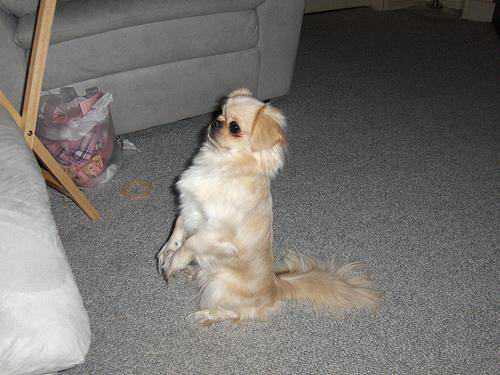

In [18]:
img = PIL.Image.open(fn); img

In [19]:
img.size

(500, 375)

In [20]:
# dictionary comprehension
size_d = {k: PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}

In [21]:
#*size_d.values()
# python-starred-expression
# http://yaoyao.codes/python/2016/09/25/python-starred-expression
row_sz, col_sz = list(zip(*size_d.values()))

In [22]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [23]:
row_sz[:5]

array([500, 500, 500, 500, 500])

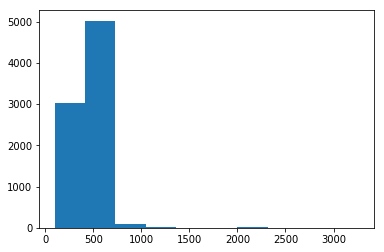

In [24]:
# histogram how high the images are
plt.hist(row_sz);

(array([ 135.,  592., 1347., 1164., 4599.,  128.,   76.,   62.,   14.,   11.]),
 array([ 97. , 185.5, 274. , 362.5, 451. , 539.5, 628. , 716.5, 805. , 893.5, 982. ]),
 <a list of 10 Patch objects>)

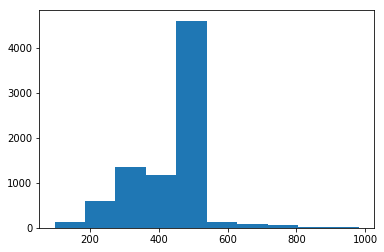

In [25]:
plt.hist(row_sz[row_sz < 1000])

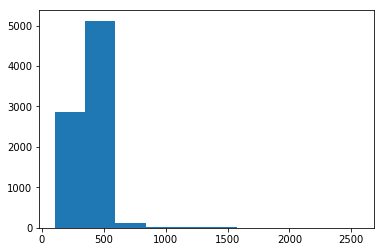

In [26]:
plt.hist(col_sz);

(array([ 235.,  733., 2205., 2979., 1807.,   98.,   27.,   33.,    7.,   10.]),
 array([102., 190., 278., 366., 454., 542., 630., 718., 806., 894., 982.]),
 <a list of 10 Patch objects>)

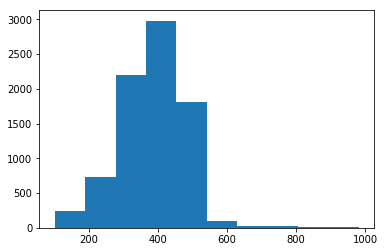

In [27]:
plt.hist(col_sz[col_sz < 1000])

In [28]:
len(data.trn_ds), len(data.test_ds)

(8178, 10357)

In [29]:
len(data.classes), data.classes[:5]

(120,
 ['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier'])

## Initial model

In [30]:
# function for resizing data - we start with small images, later on we can go with larger.
# But we can get Cuda OOM -> so we lower the batch-size
def get_data(sz, bs): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                       val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/13
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/37
    return data if sz > 300 else data.resize(340, 'tmp') # Reading the jpgs and resizing is slow for big images, so resizing them all to 340 first saves time

#Source:   
#    def resize(self, targ, new_path):
#        new_ds = []
#        dls = [self.trn_dl,self.val_dl,self.fix_dl,self.aug_dl]
#        if self.test_dl: dls += [self.test_dl, self.test_aug_dl]
#        else: dls += [None,None]
#        t = tqdm_notebook(dls)
#        for dl in t: new_ds.append(self.resized(dl, targ, new_path))
#        t.close()
#        return self.__class__(new_ds[0].path, new_ds, self.bs, self.num_workers, self.classes)
#File:      ~/fastai/courses/dl1/fastai/dataset.py

### Precompute

In [31]:
data = get_data(sz, bs)

In [32]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 179/179 [00:55<00:00,  3.96it/s]


In [33]:
# basic fit , 5 epochs
# epoch - 1 cycle through the data
# cyccle -> how many epoch in a cycle
learn.fit(1e-2, 5)

epoch      trn_loss   val_loss   accuracy                   
    0      0.93067    0.401094   0.90411   
    1      0.434837   0.293668   0.919765                    
    2      0.291274   0.274131   0.919276                    
    3      0.233052   0.254534   0.923679                    
    4      0.179266   0.253613   0.920744                    



[array([0.25361]), 0.9207436430710869]

### Augment

In [34]:
from sklearn import metrics

In [35]:
data = get_data(sz, bs)

In [36]:
# ps = p's (percents for dropouts)  
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [37]:
learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.130612   0.430625   0.899217  
    1      0.527742   0.316451   0.907045                    



[array([0.31645]), 0.907045015733536]

In [38]:
learn.precompute = False

In [39]:
learn.fit(1e-2, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.476226   0.284914   0.917808  
    1      0.439072   0.26991    0.918297                    
    2      0.397528   0.265665   0.913405                    
    3      0.349829   0.254298   0.919276                    
    4      0.326676   0.245816   0.920254                    



[array([0.24582]), 0.920254406863696]

In [40]:
learn.save('dogbreed_224_pre')

In [41]:
learn.load('dogbreed_224_pre')

In [42]:
lrf=learn.lr_find()

 84%|████████▍ | 119/141 [00:36<00:06,  3.49it/s, loss=0.881]

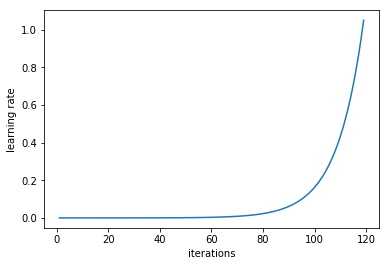

In [43]:
learn.sched.plot_lr()

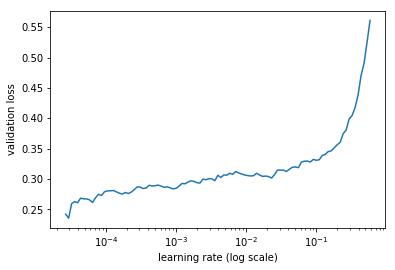

In [44]:
learn.sched.plot()

## Increase size

In [45]:
# Starting training on small images for a few epochs, then switching to bigger images, and continuing training is an amazingly effective way to avoid overfitting.

# http://forums.fast.ai/t/planet-classification-challenge/7824/96
# set_data doesn’t change the model at all. It just gives it new data to train with.
learn.set_data(get_data(299, bs)) 
learn.freeze()

#Source:   
#    def set_data(self, data, precompute=False):
#        super().set_data(data)
#        if precompute:
#            self.unfreeze()
#            self.save_fc1()
#            self.freeze()
#            self.precompute = True
#        else:
#            self.freeze()
#File:      ~/fastai/courses/dl1/fastai/conv_learner.py

In [46]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 299, 299]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 75, 75]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 75, 

In [47]:
# epoch - 1 cycle through the data
# cyccle -> how many epoch in a cycle
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.336283   0.22907    0.928082  
    1      0.308014   0.226803   0.926125                    
    2      0.297807   0.221611   0.926125                    


[array([0.22161]), 0.9261252515003406]

Validation loss is much lower than training loss. This is a sign of underfitting. Cycle_len=1 may be too short. Let's set cycle_mult=2 to find better parameter.

In [48]:
# When you are under fitting, it means cycle_len=1 is too short (learning rate is getting reset before it had the chance to zoom in properly).
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2) # 1+2+4 = 7 epochs

epoch      trn_loss   val_loss   accuracy                    
    0      0.275955   0.217914   0.929061  
    1      0.263141   0.217467   0.929061                    
    2      0.242861   0.215816   0.927593                    
    3      0.243171   0.221161   0.926614                    
    4      0.218969   0.214837   0.927593                    
    5      0.213114   0.21352    0.927104                    
    6      0.200029   0.212671   0.928082                    


[array([0.21267]), 0.9280821912559278]

Training loss and validation loss are getting closer and smaller. We are on right track.

In [49]:
log_preds, y = learn.TTA() # (5, 2044, 120), (2044,)
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9354207436399217, 0.21095394549804428)

In [50]:
len(data.val_ds.y), data.val_ds.y[:5]

(2044, array([19, 15,  7, 99, 73]))

In [51]:
learn.save('dogbreed_299_pre')

In [52]:
learn.load('dogbreed_299_pre')

In [53]:
learn.fit(1e-2, 1, cycle_len=2) # 1+1 = 2 epochs

epoch      trn_loss   val_loss   accuracy                    
    0      0.200948   0.218173   0.926125  
    1      0.192547   0.215173   0.926125                    


[array([0.21517]), 0.926125246426364]

In [54]:
learn.save('dogbreed_299_pre')

In [55]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9368884540117417, 0.20749802465611325)

This dataset is so similar to ImageNet dataset. Training convolution layers doesn't help much. We are not going to unfreeze.

## Create submission

https://youtu.be/9C06ZPF8Uuc?t=1905

In [56]:
data.classes

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [95]:
data.test_ds.fnames

['test/de084b830010b6107215fef5d4a75b94.jpg',
 'test/6b423ca7020e70eb05732843c5d2bad1.jpg',
 'test/74aa7e201e0e93e13e87b986a7d31839.jpg',
 'test/a079f72193264bc5685e5d28d7372680.jpg',
 'test/583f7580fa5fec1266331fcf83b76fd6.jpg',
 'test/72cd7496a319c832f670fbb8d349217e.jpg',
 'test/ed9e75a553dbb4712addc1638693dc03.jpg',
 'test/6322fa7edb40af844609b4843a89b5fd.jpg',
 'test/d18de4f66f7d2ae8dffb08ec13b9bbc5.jpg',
 'test/8c567325012bf8d7daeff453ec959312.jpg',
 'test/bbecb2e61f07719abe32be3f36b3fac0.jpg',
 'test/7d3a1066521da895f915af31e8e739df.jpg',
 'test/a0256a9577f2e7c6631dd78556e4bab8.jpg',
 'test/87dafc44ed8ae792ea5c341d7cbb6df4.jpg',
 'test/1f2e9080823a6b093e7a4baa668393d2.jpg',
 'test/c65172e587bf02794e5b40f830bcb2af.jpg',
 'test/4f0b2dbc23fdef5f939144f456a62140.jpg',
 'test/a5049952a1a2ea0473e6520db5e4a4fb.jpg',
 'test/685ac2356ad42163b2141a41972e5c54.jpg',
 'test/bd405393e16688e5282b57d92bdbb97b.jpg',
 'test/cbb4039e5a16f80c02f3d188f98beaf7.jpg',
 'test/18cf06b0c6a59c6891bf6f5a42b

In [96]:
log_preds, y = learn.TTA(is_test=True) # use test dataset rather than validation dataset
probs = np.mean(np.exp(log_preds),0)
#accuracy_np(probs, y), metrcs.log_loss(y, probs) # This does not make sense since test dataset has no labels

In [97]:
probs.shape # (n_images, n_classes)

(10357, 120)

In [98]:
df = pd.DataFrame(probs)
df.columns = data.classes

In [99]:
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])

In [100]:
df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,de084b830010b6107215fef5d4a75b94,2.247048e-08,5.574502e-07,3.681719e-08,3.269305e-08,3.547173e-08,3.298868e-08,1.025481e-08,1.417199e-08,8.700473e-09,...,9.358684e-10,3.589490e-09,2.157270e-08,1.694793e-08,9.384597e-08,4.990889e-08,6.101275e-09,3.453411e-07,1.649283e-08,2.441560e-09
1,6b423ca7020e70eb05732843c5d2bad1,7.582547e-06,1.388717e-05,1.746069e-07,2.040628e-06,6.267339e-07,6.887335e-09,2.795896e-08,2.194484e-07,1.958241e-07,...,1.010043e-07,1.285715e-07,6.261421e-08,1.793479e-07,1.799862e-08,1.960520e-07,9.588302e-06,4.191500e-07,5.329080e-06,9.861136e-08
2,74aa7e201e0e93e13e87b986a7d31839,1.027102e-05,2.299651e-06,6.321819e-06,2.784797e-03,9.752674e-06,4.674553e-06,6.442232e-06,1.012436e-05,1.059099e-06,...,4.675650e-06,2.305696e-05,3.550390e-06,5.613023e-06,8.927980e-06,1.537664e-06,1.826299e-05,2.044362e-05,2.905504e-01,1.959356e-06
3,a079f72193264bc5685e5d28d7372680,6.443643e-05,2.200352e-06,3.003749e-06,1.808636e-05,5.075205e-06,6.518222e-07,5.569359e-06,7.453322e-07,9.494549e-07,...,1.170134e-06,1.846260e-06,6.348965e-07,9.115518e-07,3.061384e-06,1.364195e-06,5.049321e-05,1.384389e-06,1.279709e-03,4.294207e-05
4,583f7580fa5fec1266331fcf83b76fd6,4.872059e-07,1.116747e-08,2.368724e-07,1.556485e-06,1.718904e-08,3.177167e-07,6.466888e-08,5.951816e-09,3.472320e-10,...,5.578445e-08,1.796591e-08,5.679023e-09,1.610486e-09,1.884359e-07,5.007061e-07,3.053912e-09,4.251438e-07,8.928684e-07,6.154019e-08


In [101]:
SUBM = f'{PATH}/subm/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)

In [102]:
FileLink(f'{SUBM}subm.gz')

/home/paperspace/fastai/courses/dl1/data/dogbreed/subm/subm.gz

## Individual prediction

In [57]:
fn = data.val_ds.fnames[1]
fn

'train/00214f311d5d2247d5dfe4fe24b2303d.jpg'

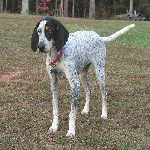

In [58]:
Image.open(PATH + fn).resize((150, 150))

In [59]:
# Method 1.
trn_tfms, val_tfms = tfms_from_model(arch, sz)
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
np.argmax(preds)

15

In [60]:
learn.data.classes[np.argmax(preds)]

'bluetick'

In [61]:
# Method 2.
trn_tfms, val_tfms = tfms_from_model(arch, sz)
im = val_tfms(open_image(PATH + fn)) # open_image() returns numpy.ndarray
preds = learn.predict_array(im[None])
np.argmax(preds)

15